<a href="https://colab.research.google.com/github/jovanape/Bitcoint-Price-Prediction/blob/main/rnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
# Ucitavanje biblioteka

import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [22]:
# Ucitavanje skupa podataka

data = pd.read_csv('bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv')
data

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.000000,4.390000
1,1325317980,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1325318040,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1325318100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1325318160,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
4857372,1617148560,58714.31,58714.31,58686.00,58686.00,1.384487,81259.372187,58692.753339
4857373,1617148620,58683.97,58693.43,58683.97,58685.81,7.294848,428158.146640,58693.226508
4857374,1617148680,58693.43,58723.84,58693.43,58723.84,1.705682,100117.070370,58696.198496
4857375,1617148740,58742.18,58770.38,58742.18,58760.59,0.720415,42332.958633,58761.866202


In [23]:
# Ciscenje podataka od NaN vrednosti

data = data.dropna()
data

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.000000,4.390000
478,1325346600,4.39,4.39,4.39,4.39,48.000000,210.720000,4.390000
547,1325350740,4.50,4.57,4.50,4.57,37.862297,171.380338,4.526411
548,1325350800,4.58,4.58,4.58,4.58,9.000000,41.220000,4.580000
1224,1325391360,4.58,4.58,4.58,4.58,1.502000,6.879160,4.580000
...,...,...,...,...,...,...,...,...
4857372,1617148560,58714.31,58714.31,58686.00,58686.00,1.384487,81259.372187,58692.753339
4857373,1617148620,58683.97,58693.43,58683.97,58685.81,7.294848,428158.146640,58693.226508
4857374,1617148680,58693.43,58723.84,58693.43,58723.84,1.705682,100117.070370,58696.198496
4857375,1617148740,58742.18,58770.38,58742.18,58760.59,0.720415,42332.958633,58761.866202


In [35]:
# Kreiranje datuma

data['Date'] = pd.to_datetime(data['Timestamp'], unit='s').dt.date # samo datum (bez vremena)


# Filtriranje podataka

data = data.loc[data['Date'] > pd.to_datetime('2021-01-28')]
data.head(4)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,Date
4769536,1611878400,33488.66,33511.60,33466.63,33466.63,3.680964,123253.27055,33483.968039,2021-01-29
4769537,1611878460,33462.73,33604.79,33435.24,33596.50,13.756321,461774.39554,33568.161717,2021-01-29
4769538,1611878520,33566.89,33662.45,33566.89,33636.53,12.618299,424345.02877,33629.337533,2021-01-29
4769539,1611878580,33655.74,33701.33,33637.28,33667.37,20.345956,685016.35953,33668.428338,2021-01-29


In [25]:
# Dimenzije DataFrame-a

data.shape

(87724, 9)

In [26]:
# Definicija funkcije za podelu podataka na train i test skup

def data_split(data, test_size = 0, days_to_predict = 0):

  if test_size == 0 and days_to_predict == 0:
    print('Uneti vrednost za jedan od parametara test_size ili days_to_predict.\n')
    return
  elif test_size == 0: # dato je days_to_predict
    test_limit = len(data) - prediction_days
  else: # dato je test_size ili oba parametra
    test_limit = len(data) - int(test_size * len(data))

  train = data[:test_limit]
  test = data[test_limit:]
  
  return train, test

In [27]:
# Izvrsavanje funkcije za podelu podataka na train i test skup

train, test = data_split(data, test_size = 0.2, days_to_predict = 0)

In [28]:
# Dimenzije train i test skupa

train.shape, test.shape

((70180, 9), (17544, 9))

In [29]:
data.shape

(87724, 9)

In [30]:
# Definicija funkcije za vizuelni prikaz train i test podataka

def plot_data(train_data = train['Close'], test_data = test['Close']):

  fig, ax = plt.subplots(1, figsize=(16, 9))
  ax.plot(train_data, label='trening', linewidth=2)
  ax.plot(test_data, label='test', linewidth=2)
  ax.set_ylabel('cena [USD]', fontsize=14)
  ax.set_title(label = 'Vizuelni prikaz skupova za trening i test', fontsize=18)
  ax.legend(loc='best', fontsize=18)

  #data = data.reset_index()
  #x = data.index
  #ax.set_xticks(range(87724))


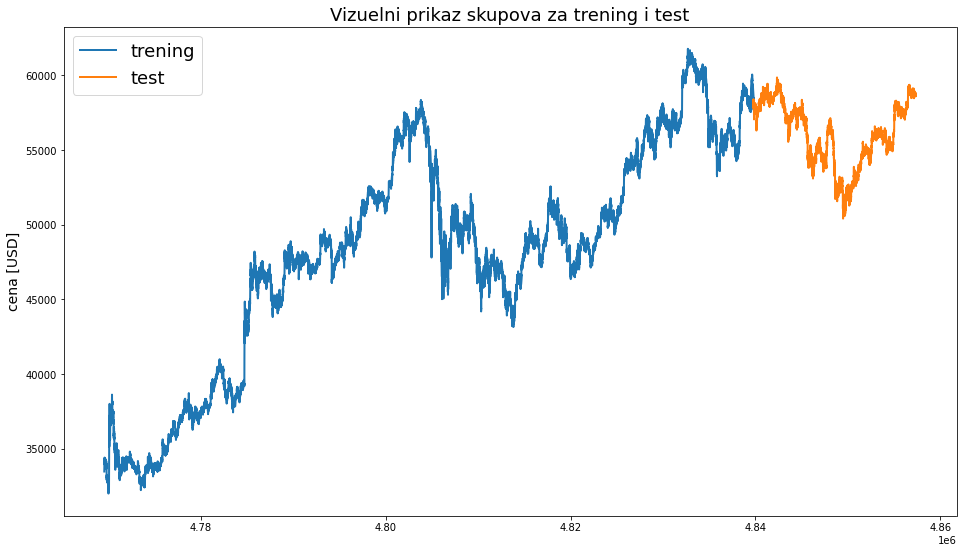

In [31]:
# Poziv funkcije za plotovanje train i test podataka

plot_data(train_data = train['Close'], test_data = test['Close'])

In [36]:
# Izbacivanje nepotrebnih kolona (atributa) iz train skupa

train_ = train.drop(['Date', 'Volume_(BTC)', 'Volume_(Currency)', 'Weighted_Price', 'Timestamp'], axis = 1)
train_.head()

,Open,High,Low,Close
4769536,33488.66,33511.60,33466.63,33466.63
4769537,33462.73,33604.79,33435.24,33596.50
4769538,33566.89,33662.45,33566.89,33636.53
4769539,33655.74,33701.33,33637.28,33667.37
4769540,33690.78,33782.29,33674.85,33767.33


In [37]:
# Dimenzije train skupa - pre i nakon izbacivanja atributa

train.shape, train_.shape

((70180, 9), (70180, 4))

In [38]:
# Skaliranje trening skupa

scaler = MinMaxScaler(feature_range=(0, 1))
train_ = scaler.fit_transform(train_)
train_

array([[0.05033526, 0.04979255, 0.04974573, 0.04956498],
       [0.04946436, 0.05292481, 0.04868825, 0.05392423],
       [0.05296276, 0.05486286, 0.05312336, 0.05526789],
       ...,
       [0.87851268, 0.87780909, 0.87696148, 0.87392403],
       [0.87465086, 0.87824133, 0.87711342, 0.87682282],
       [0.87704897, 0.87859963, 0.878938  , 0.87800099]])

In [39]:
# Odredjivanje ciljne promenljive na train skupu

X_train = []
y_train = []

for i in range(60, train_.shape[0]):
    X_train.append(train_[i-60:i])
    y_train.append(train_[i,0])

In [40]:
# Konverzija u np.array

X_train, y_train = np.array(X_train), np.array(y_train)

In [41]:
# Dimenzije X_train

X_train.shape

(70120, 60, 4)

In [42]:
# Definicija funkcije koja kreira i vraca model mreze

def build_net(input_1 = X_train.shape[1], input_2 = X_train.shape[2]):

  net = Sequential()
  net.add(LSTM(units = 50, activation = 'relu', return_sequences = True, input_shape = (input_1, input_2)))
  net.add(Dropout(0.2))
  net.add(LSTM(units = 60, activation = 'relu', return_sequences = True))
  net.add(Dropout(0.3))

  net.add(LSTM(units = 80, activation = 'relu', return_sequences = True))
  net.add(Dropout(0.4))

  net.add(LSTM(units = 120, activation = 'relu'))
  net.add(Dropout(0.5))

  net.add(Dense(units =1))
  print(net.summary())

  return net


In [43]:
# Poziv funkcije za kreiranje modela mreze

net = build_net(input_1 = X_train.shape[1], input_2 = X_train.shape[2])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 50)            11000     
_________________________________________________________________
dropout (Dropout)            (None, 60, 50)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 60, 60)            26640     
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 60)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 60, 80)            45120     
_________________________________________________________________
dropout_2 (Dropout)          (None, 60, 80)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 120)               9

In [44]:
# Kompilacija i treniranje mreze

net.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['accuracy'])
history = net.fit(X_train, y_train, epochs = 20, batch_size =50)

Epoch 1/20
1403/1403 [==============================] - 304s 195ms/step - loss: 0.0158 - accuracy: 8.0747e-06
Epoch 2/20
1403/1403 [==============================] - 273s 195ms/step - loss: 0.0026 - accuracy: 1.2338e-05
Epoch 3/20
1403/1403 [==============================] - 278s 198ms/step - loss: 0.0017 - accuracy: 2.5512e-05
Epoch 4/20
1403/1403 [==============================] - 275s 196ms/step - loss: 0.0016 - accuracy: 2.9405e-05
Epoch 5/20
1403/1403 [==============================] - 274s 195ms/step - loss: 0.0016 - accuracy: 2.0263e-05
Epoch 6/20
1403/1403 [==============================] - 274s 195ms/step - loss: 0.0016 - accuracy: 2.9316e-05
Epoch 7/20
1403/1403 [==============================] - 274s 195ms/step - loss: 0.0015 - accuracy: 3.8356e-05
Epoch 8/20
1403/1403 [==============================] - 273s 195ms/step - loss: 0.0015 - accuracy: 1.2321e-05
Epoch 9/20
1403/1403 [==============================] - 274s 195ms/step - loss: 0.0016 - accuracy: 4.8267e-06
Epoch 10/2

In [45]:
# Izbacivanje nepotrebnih kolona (atributa) iz test skupa

test_ = test.drop(['Date', 'Volume_(BTC)', 'Volume_(Currency)', 'Weighted_Price', 'Timestamp'], axis = 1)


# Skaliranje test skupa

test_ = scaler.transform(test_)


# Odredjivanje ciljne (target) promenljive na test skupu

X_test = []
y_test = []

for i in range(60, test_.shape[0]):
    X_test.append(test_[i-60:i])
    y_test.append(test_[i,0])


# Konverzija u np.array
X_test, y_test = np.array(X_test), np.array(y_test)


# Predvidjanje

y_predicted = net.predict(X_test)
y_predicted

array([[0.7753589 ],
       [0.7750528 ],
       [0.7746129 ],
       ...,
       [0.79963434],
       [0.79970676],
       [0.79981804]], dtype=float32)

In [46]:
# Dimenzije test skupa

test.shape

(17544, 9)

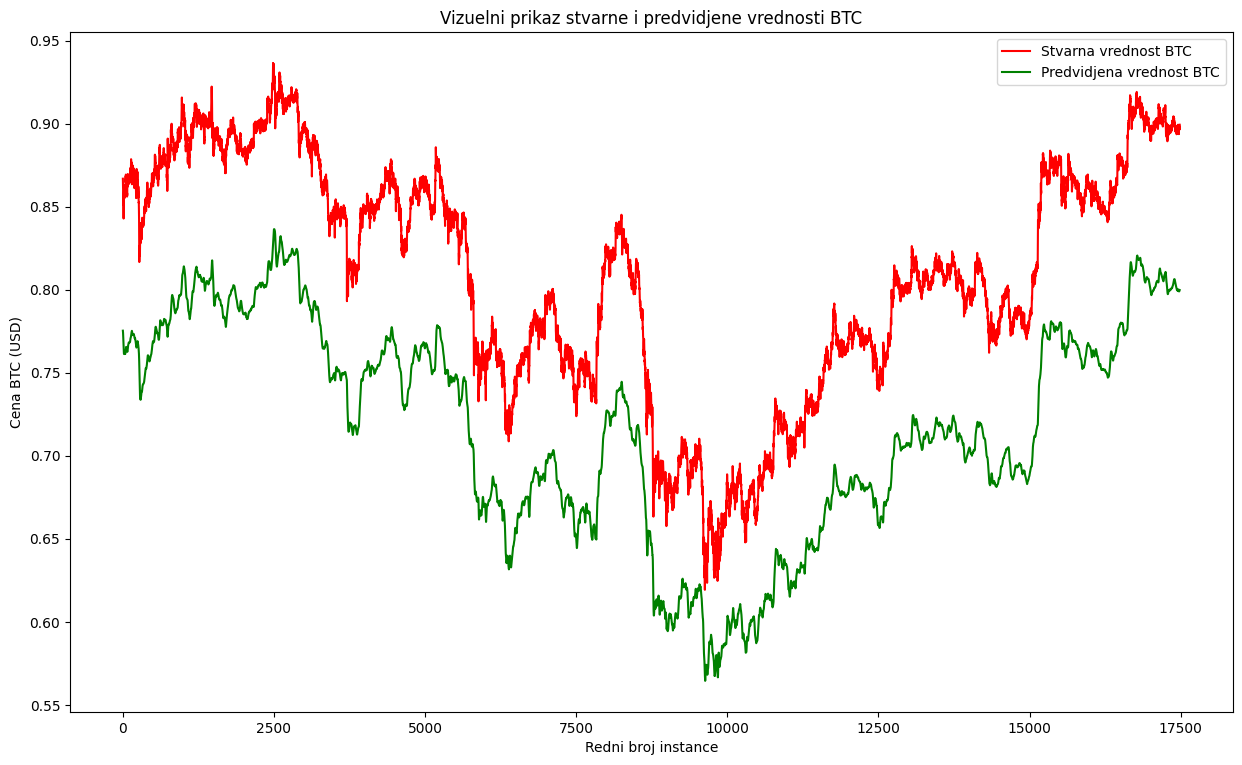

In [47]:
# Vizuelni prikaz rezultata modela mreze

plt.figure(figsize=(15,9), dpi=100, facecolor='w', edgecolor='k')
ax = plt.gca()

plt.title('Vizuelni prikaz stvarne i predvidjene vrednosti BTC')
plt.plot(y_test, color = 'red', label = 'Stvarna vrednost BTC')
plt.plot(y_predicted, color = 'green', label = 'Predvidjena vrednost BTC')

#test = test.reset_index()
#x = test.index

#plt.xticks(x, labels = data[(len(data) - int(0.2 * len(data))):]['Date'], rotation = 'vertical')
plt.xlabel('Redni broj instance')
plt.ylabel('Cena BTC (USD)')
plt.legend(loc='best')
plt.show()

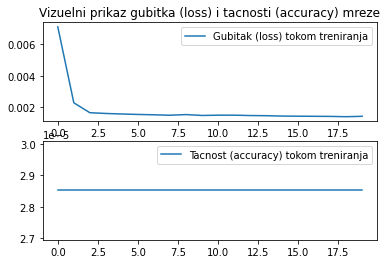

In [48]:
# Vizuelni prikaz gubitka (loss) tokom treniranja mreze

plt.subplot(211)
# plt.title('Gubitak (Loss)')
epochs = range(len(history.history['loss']))
plt.plot(epochs, history.history['loss'], label='Gubitak (loss) tokom treniranja')
#plt.plot(epochs, history.history['val_loss'], label='Gubitak (val_loss) tokom validacije')

plt.legend()

plt.title('Vizuelni prikaz gubitka (loss) i tacnosti (accuracy) mreze')

# Vizuelni prikaz tacnosti (accuracy) tokom treniranja mreze

plt.subplot(212)
# plt.title('Tacnost (Accuracy)')
plt.plot(epochs, history.history['accuracy'], label='Tacnost (accuracy) tokom treniranja')
#plt.plot(epochs, history.history['val_accuracy'], label='Tacnost (val_accuracy) tokom validacije')

plt.legend()

plt.show()